# Notebook API Python Spark GraphFrames-2024

**GraphFrames Quick-Start Guide:**
*   https://graphframes.github.io/graphframes/docs/_site/quick-start.html

**GraphFrames User Guide:**
*   https://graphframes.github.io/graphframes/docs/_site/user-guide.html

**GraphFrames Python API**
*   https://graphframes.github.io/graphframes/docs/_site/api/python/index.html



## Preparation
*   ***Check that computing resources*** are allocated to your notebook if it is
connected (see disk RAM indicated at top right). If not, click on the connect button to obtain resources.

*   ***Create the directory*** to store the necessary files on your google
drive (give the notebook permission to access your drive when requested). *Adjust the name of your folder* : **MyDrive/ens/esilv/data/**

***Install pyspark and findspark:***

In [10]:
!pip install -q pyspark
!pip install -q findspark

***Install GraphFrames :***

In [2]:
!pip install -q graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100   164  100   164    0     0    792      0 --:--:-- --:--:-- --:--:--   792
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file 
100   146  100   146    0     0    241      0 --:--:-- --:--:-- --:--:--   501
curl: (23) Failed writing body (0 != 146)


***Start the spark session:***

In [11]:
import os
os.environ["SPARK_HOME"] = "/home/djeghali/.local/bin/pyspark"
os.environ["JAVA_HOME"] = "/usr/bin/java"

In [12]:
# Main imports
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

import pandas as pd


# initialise environment variables for spark
findspark.init()

# Start spark session
# --------------------------
def start_spark():
  local = "local[*]"
  appName = "TP"

  gf = "graphframes:graphframes:0.8.3-spark3.5-s_2.12"

  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.jars.packages", gf)

  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")

  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # Adjust the query execution environment to the size of the cluster (4 cores)
  spark.conf.set("spark.sql.shuffle.partitions","4")
  print("session started, its id is ", sc.applicationId)
  return spark
spark = start_spark()

NotADirectoryError: [Errno 20] Not a directory: '/home/djeghali/.local/bin/pyspark/./bin/spark-submit'

In [9]:
#Import GraphFrames
from graphframes import GraphFrame
from graphframes.lib import AggregateMessages as AM
from graphframes.lib import Pregel

#For connectedComponents()
# !pwd
# !mkdir /content/checkpoints
# spark.sparkContext.setCheckpointDir('/content/checkpoints')

#Import networkx
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

/content
mkdir: cannot create directory ‘/content/checkpoints’: File exists


In [11]:
# Initialisez une session Spark
spark = SparkSession.builder.appName("LectureParquet").getOrCreate()
# Chemin vers le fichier Parquet compressé avec Snappy
parquet_file = "part-00000-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet"

# Lisez le fichier Parquet dans un DataFrame PySpark
df = spark.read.format("parquet").option("compression", "snappy").load(parquet_file)

# Affichez le contenu du DataFrame
df.show()


+-----------+-----------+-----+
|     seqID1|     seqID2|  sim|
+-----------+-----------+-----+
|117761605:5|152890023:5| 97.8|
|152904885:3|155591878:2| 88.5|
|152887848:4|153682181:0|100.0|
|152937692:5| 80009514:2| 82.3|
|152990923:2|154549183:4| 98.0|
|152867782:1|153171917:1| 83.1|
| 15111981:2|153137370:1|100.0|
|152794195:0| 15280704:2| 96.9|
| 62963742:1| 63783418:5| 98.4|
|152170568:3|153062631:2| 97.6|
|152904832:4|154500443:5| 98.6|
|152745429:3| 22988511:2|100.0|
|153161980:3|154256473:0|100.0|
|152903373:4|154426964:5| 80.4|
|146010871:1|158434400:4| 98.7|
|153040013:0|156563807:1| 96.5|
|152933621:4|157634534:2| 96.8|
|153141720:0|155282497:0| 93.2|
|153082115:5|153887336:3| 90.0|
|153025447:3|155660759:1| 97.4|
+-----------+-----------+-----+
only showing top 20 rows



In [12]:

# Créez un DataFrame distinct contenant tous les identifiants uniques de sommets
vertices = df.selectExpr("seqID1 as id").union(df.selectExpr("seqID2 as id")).distinct()

# Créez un DataFrame d'arêtes avec les colonnes "src", "dst", et "sim"
edges = df.select("seqID1", "seqID2", "sim").withColumnRenamed("seqID1", "src").withColumnRenamed("seqID2", "dst")
edges
# Créez le GraphFrame
graph = GraphFrame(vertices, edges)

# Affichez la structure du GraphFrame
graph.vertices.show()
graph.edges.show()

# Faites des opérations sur le graphe si nécessaire
# par exemple, pour afficher les voisins d'un sommet
graph.edges.filter("src = '117761605:5'").show()

+-----------+
|         id|
+-----------+
|152904885:3|
|152887848:4|
|152937692:5|
|152990923:2|
|152794195:0|
|152904832:4|
|152745429:3|
|153161980:3|
|152903373:4|
|153040013:0|
|152933621:4|
|153141720:0|
|153082115:5|
|153025447:3|
|152921945:1|
|118345154:5|
|152901882:2|
|152772567:4|
|131035323:5|
|152897014:5|
+-----------+
only showing top 20 rows

+-----------+-----------+-----+
|        src|        dst|  sim|
+-----------+-----------+-----+
|117761605:5|152890023:5| 97.8|
|152904885:3|155591878:2| 88.5|
|152887848:4|153682181:0|100.0|
|152937692:5| 80009514:2| 82.3|
|152990923:2|154549183:4| 98.0|
|152867782:1|153171917:1| 83.1|
| 15111981:2|153137370:1|100.0|
|152794195:0| 15280704:2| 96.9|
| 62963742:1| 63783418:5| 98.4|
|152170568:3|153062631:2| 97.6|
|152904832:4|154500443:5| 98.6|
|152745429:3| 22988511:2|100.0|
|153161980:3|154256473:0|100.0|
|152903373:4|154426964:5| 80.4|
|146010871:1|158434400:4| 98.7|
|153040013:0|156563807:1| 96.5|
|152933621:4|157634534:2| 96.8

In [13]:
# alternatives to Databricks display function.
from google.colab import data_table

def display(df, n=100):
  return data_table.DataTable(df.limit(n).toPandas(), include_index=False, num_rows_per_page=10)

def display2(df, n=20):
  pd.set_option('max_columns', None)
  pd.set_option('max_colwidth', None)
  return df.limit(n).toPandas()

In [14]:
def plot_directed_graph(gf):

  gplot = nx.DiGraph()
  edge_labels = {}

  plt.figure(figsize=(6, 7))
  for node in gf.vertices.select('id').take(1000):
    gplot.add_node(node['id'])

  for row in gf.edges.select('src', 'dst', 'sim').take(1000):
    gplot.add_edge(row['src'], row['dst'])
    edge_labels[(row['src'], row['dst'])] = row['sim']

  pos = nx.shell_layout(gplot)

  nx.draw(gplot,
          pos,
          with_labels=True,
          font_weight='bold',
          node_size=1800,
          font_size=15,
          node_color='orange',
          width=2)

  nx.draw_networkx_edge_labels(gplot,
                               pos,
                               edge_labels=edge_labels,
                               font_color='red',
                               font_size=10,
                               font_weight='bold')

In [15]:
def plot_bar(df, x_limit, xcolname,  ycolname, rotation=True):

    plt.style.use('fivethirtyeight')
    ax = (df
      .toPandas()
      .head(x_limit)
      .plot(kind='bar', x=xcolname, y=ycolname, legend=None))
    ax.xaxis.set_label_text("")
    if rotation:
      plt.xticks(rotation=45)
    plt.tight_layout()

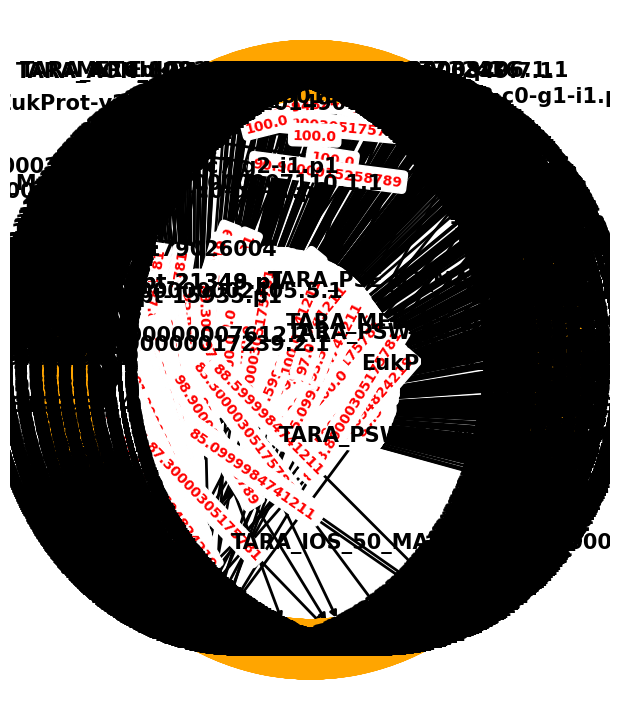

In [16]:
plot_directed_graph(graph)

In [64]:
e1 = graph.edges.filter("sim < 81")
e1.show()


+-----------+-----------+----+
|        src|        dst| sim|
+-----------+-----------+----+
|152903373:4|154426964:5|80.4|
|152797616:4|153077244:3|80.9|
|153099598:1|155793668:2|80.8|
|150647705:2|152844438:1|80.0|
|152541720:4|152976092:5|80.0|
|152906505:5|156737433:1|80.3|
|152883941:1|156128592:5|80.0|
|153178532:1| 45583616:0|80.0|
|152834429:2|153555005:5|80.0|
|153030596:4|154175138:0|80.0|
|153036485:1|156270867:1|80.6|
|153029052:1|153226308:3|80.9|
|153181167:5|153924587:5|80.0|
|152857993:1|  8967796:1|80.6|
|101683497:0|101731577:3|80.0|
|152449806:3|152748726:1|80.9|
|  4380709:5| 85714224:3|80.0|
|153486550:3|153681783:2|80.0|
|126635248:5|131579132:2|80.4|
| 28993068:4| 58277224:1|80.6|
+-----------+-----------+----+
only showing top 20 rows

+-----------+-----------+----+
|        src|        dst| sim|
+-----------+-----------+----+
|152903373:4|154426964:5|80.4|
|152797616:4|153077244:3|80.9|
|153099598:1|155793668:2|80.8|
|150647705:2|152844438:1|80.0|
|152541720:4|

In [65]:
e2 = e1.limit(5)
e2.show()

+-----------+-----------+----+
|        src|        dst| sim|
+-----------+-----------+----+
|152903373:4|154426964:5|80.4|
|152797616:4|153077244:3|80.9|
|153099598:1|155793668:2|80.8|
|150647705:2|152844438:1|80.0|
|152541720:4|152976092:5|80.0|
+-----------+-----------+----+



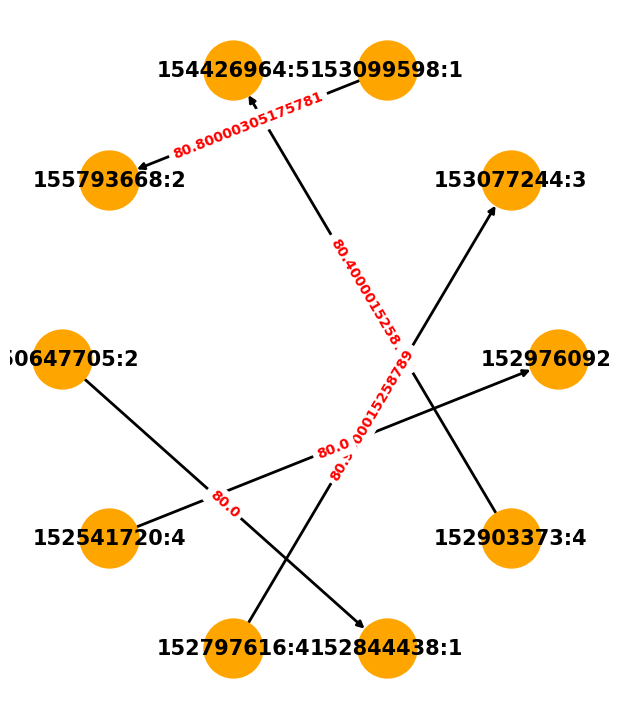

In [66]:
g2 = GraphFrame(graph.vertices, e2)
g3 = g2.dropIsolatedVertices()
plot_directed_graph(g3)



In [68]:
!pip install igraph


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.2 MB/s eta 0:00:00


In [70]:
connected_components = g3.connectedComponents()

# Affichez les composantes connexes
connected_components.show()

+-----------+---------+
|         id|component|
+-----------+---------+
|150647705:2|        0|
|152541720:4|        1|
|152797616:4|        2|
|152844438:1|        0|
|152903373:4|        4|
|152976092:5|        1|
|153077244:3|        2|
|153099598:1|        7|
|154426964:5|        4|
|155793668:2|        7|
+-----------+---------+



**Working on a small example graph**

In [ ]:
# Vertex DataFrame
v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)
], ["id", "name", "age"])


In [ ]:
v.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



In [ ]:
# Edge DataFrame
e = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])

In [ ]:
# Create a GraphFrame
g = GraphFrame(v, e)

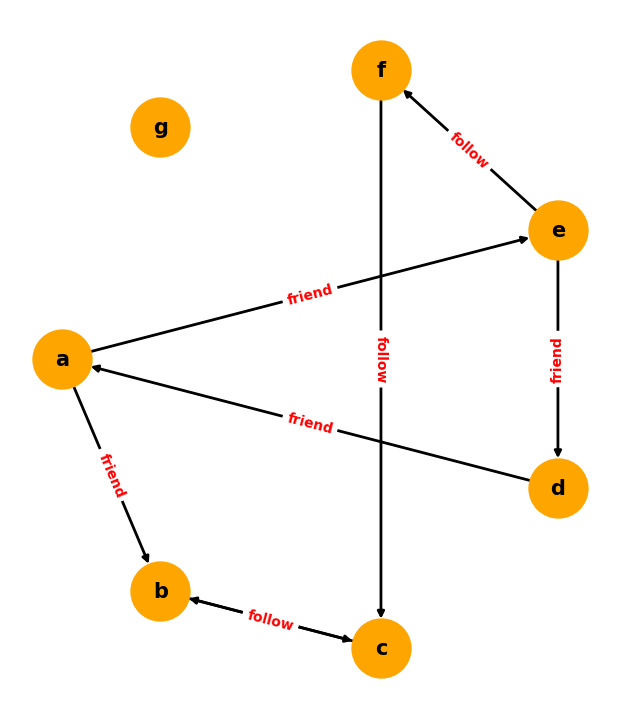

In [ ]:
plot_directed_graph(g)

**dropIsolatedVertices**

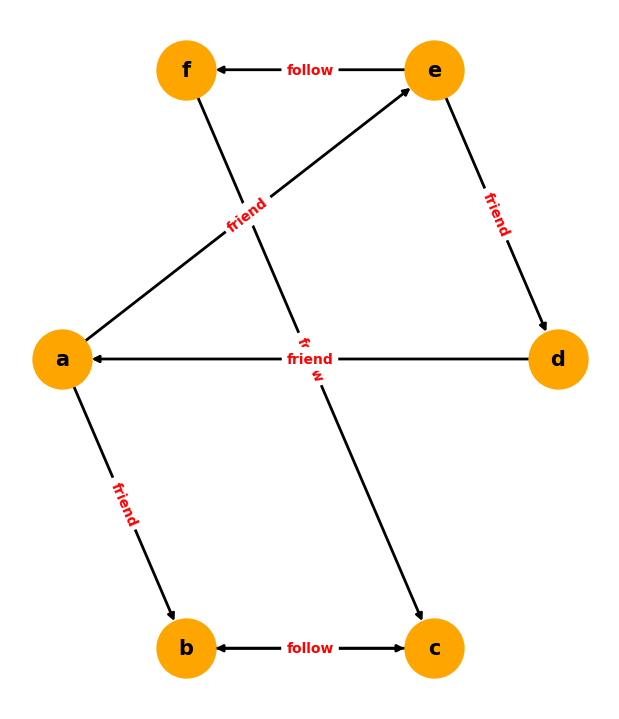

In [ ]:
g=g.dropIsolatedVertices()
plot_directed_graph(g)

**Views**

In [ ]:
g.vertices.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)



In [ ]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+



In [ ]:
g.edges.printSchema()

root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- relationship: string (nullable = true)



In [ ]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



In [ ]:
g.triplets.printSchema()

root
 |-- src: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- age: long (nullable = true)
 |-- edge: struct (nullable = false)
 |    |-- src: string (nullable = true)
 |    |-- dst: string (nullable = true)
 |    |-- relationship: string (nullable = true)
 |-- dst: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- age: long (nullable = true)



In [ ]:
g.triplets.show()

+----------------+--------------+----------------+
|             src|          edge|             dst|
+----------------+--------------+----------------+
|  {d, David, 29}|{d, a, friend}|  {a, Alice, 34}|
|  {a, Alice, 34}|{a, b, friend}|    {b, Bob, 36}|
|{c, Charlie, 30}|{c, b, follow}|    {b, Bob, 36}|
|    {b, Bob, 36}|{b, c, follow}|{c, Charlie, 30}|
|  {f, Fanny, 36}|{f, c, follow}|{c, Charlie, 30}|
| {e, Esther, 32}|{e, d, friend}|  {d, David, 29}|
|  {a, Alice, 34}|{a, e, friend}| {e, Esther, 32}|
| {e, Esther, 32}|{e, f, follow}|  {f, Fanny, 36}|
+----------------+--------------+----------------+



**Basic graph and DataFrame queries**

In [ ]:
# Get a DataFrame with columns "id" and "inDegree" (in-degree)
vertexInDegrees = g.inDegrees
vertexInDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       2|
|  f|       1|
|  d|       1|
|  a|       1|
|  e|       1|
+---+--------+



**Motif finding**

In [ ]:
# Search for pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

+----------------+--------------+----------------+--------------+
|               a|             e|               b|            e2|
+----------------+--------------+----------------+--------------+
|{c, Charlie, 30}|{c, b, follow}|    {b, Bob, 36}|{b, c, follow}|
|    {b, Bob, 36}|{b, c, follow}|{c, Charlie, 30}|{c, b, follow}|
+----------------+--------------+----------------+--------------+



In [ ]:
#Friends of friends
fof = g.find("(x)-[]->(y); (y)-[]->(z); !(x)-[]->(z)").filter("x.id != z.id")
fof.select(col('x.id').alias('x'), col('y.id').alias('y'), col('z.id').alias('z')).show()

+---+---+---+
|  x|  y|  z|
+---+---+---+
|  a|  e|  d|
|  d|  a|  b|
|  d|  a|  e|
|  a|  b|  c|
|  e|  d|  a|
|  f|  c|  b|
|  e|  f|  c|
|  a|  e|  f|
+---+---+---+



**Subgraphs**

In [ ]:
# First application

# Select subgraph of users older than 30, and relationships of type "friend".
# Drop isolated vertices (users) which are not contained in any edges (relationships).
g1 = g.filterVertices("age > 30").filterEdges("relationship = 'friend'").dropIsolatedVertices()

In [ ]:
g.vertices.filter("age > 30").show()

+---+------+---+
| id|  name|age|
+---+------+---+
|  a| Alice| 34|
|  b|   Bob| 36|
|  e|Esther| 32|
|  f| Fanny| 36|
|  g| Gabby| 60|
+---+------+---+



In [ ]:
g.edges.filter("relationship = 'friend'").show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



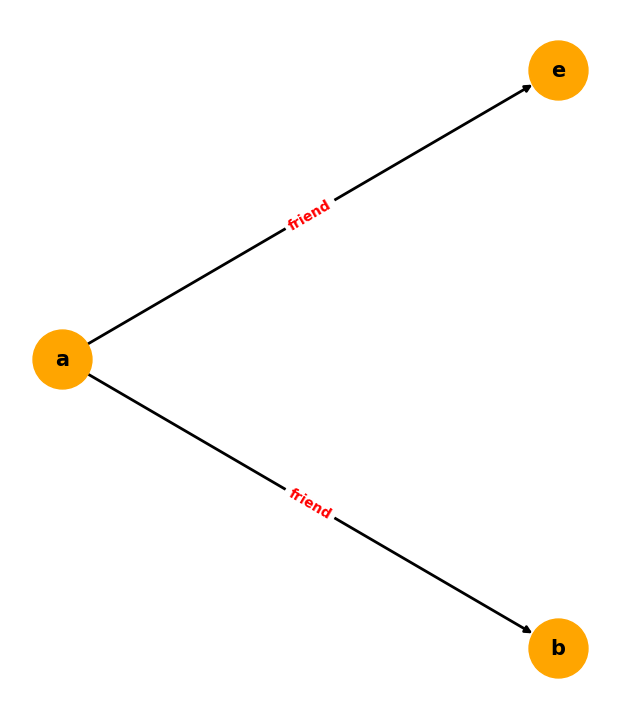

In [ ]:
plot_directed_graph(g1)

In [ ]:
# Second Application

# Select subgraph based on edges "e" of type "follow"
# pointing from a younger user "a" to an older user "b".
paths = g.find("(a)-[e]->(b)")\
  .filter("e.relationship = 'follow'")\
  .filter("a.age < b.age")
# "paths" contains vertex info. Extract the edges.
e2 = paths.select("e.src", "e.dst", "e.relationship")

In [ ]:
e2.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  c|  b|      follow|
|  e|  f|      follow|
+---+---+------------+



In [ ]:
g.triplets.filter("src.age < dst.age").show()

+----------------+--------------+--------------+
|             src|          edge|           dst|
+----------------+--------------+--------------+
|  {d, David, 29}|{d, a, friend}|{a, Alice, 34}|
|  {a, Alice, 34}|{a, b, friend}|  {b, Bob, 36}|
|{c, Charlie, 30}|{c, b, follow}|  {b, Bob, 36}|
| {e, Esther, 32}|{e, f, follow}|{f, Fanny, 36}|
+----------------+--------------+--------------+



In [ ]:
e2.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  c|  b|      follow|
|  e|  f|      follow|
+---+---+------------+



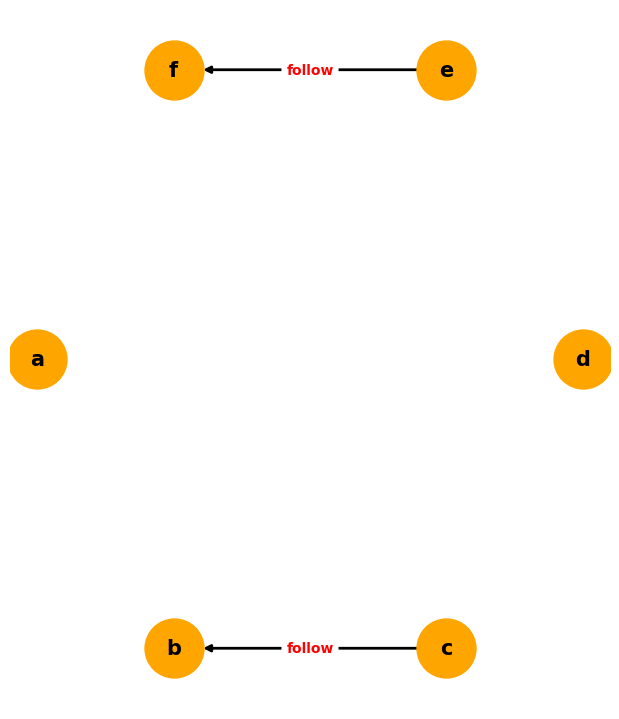

In [ ]:
# Construct the subgraph
g2 = GraphFrame(g.vertices, e2)
plot_directed_graph(g2)

****Graph algorithms****

**BFS**

In [ ]:
# Search from "Esther" for users of age < 32.
g.bfs("name = 'Esther'", "age < 32",\
  edgeFilter="relationship != 'friend'", maxPathLength=3).show()

+---------------+--------------+--------------+--------------+----------------+
|           from|            e0|            v1|            e1|              to|
+---------------+--------------+--------------+--------------+----------------+
|{e, Esther, 32}|{e, f, follow}|{f, Fanny, 36}|{f, c, follow}|{c, Charlie, 30}|
+---------------+--------------+--------------+--------------+----------------+



**Connected components**

In [ ]:
g.connectedComponents().orderBy("component").show()

+---+-------+---+---------+
| id|   name|age|component|
+---+-------+---+---------+
|  a|  Alice| 34|        0|
|  b|    Bob| 36|        0|
|  c|Charlie| 30|        0|
|  d|  David| 29|        0|
|  e| Esther| 32|        0|
|  f|  Fanny| 36|        0|
+---+-------+---+---------+



**Strongly connected components**

In [ ]:
g.stronglyConnectedComponents(maxIter=10).orderBy("component").show()

+---+-------+---+---------+
| id|   name|age|component|
+---+-------+---+---------+
|  a|  Alice| 34|        0|
|  d|  David| 29|        0|
|  e| Esther| 32|        0|
|  b|    Bob| 36|        1|
|  c|Charlie| 30|        1|
|  f|  Fanny| 36|        5|
+---+-------+---+---------+



**LPA**

In [ ]:
g.labelPropagation(maxIter=3).show()

+---+-------+---+-----+
| id|   name|age|label|
+---+-------+---+-----+
|  a|  Alice| 34|    4|
|  b|    Bob| 36|    2|
|  c|Charlie| 30|    1|
|  d|  David| 29|    2|
|  e| Esther| 32|    5|
|  f|  Fanny| 36|    2|
+---+-------+---+-----+



**Page Rank**

In [ ]:
# Run PageRank until convergence to tolerance "tol".
results = g.pageRank(resetProbability=0.15, tol=0.01)

In [ ]:
results.vertices.select("id", "pagerank").show()
results.edges.select("src", "dst", "weight").show()

+---+-------------------+
| id|           pagerank|
+---+-------------------+
|  a|0.39510717965314035|
|  b|  2.336217781395228|
|  c| 2.3646536321108544|
|  d|0.28887960636988763|
|  e| 0.3262621941010017|
|  f|0.28887960636988763|
+---+-------------------+

+---+---+------+
|src|dst|weight|
+---+---+------+
|  a|  b|   0.5|
|  a|  e|   0.5|
|  b|  c|   1.0|
|  c|  b|   1.0|
|  d|  a|   1.0|
|  e|  d|   0.5|
|  e|  f|   0.5|
|  f|  c|   1.0|
+---+---+------+



**Shortest paths**

In [ ]:
g.shortestPaths(landmarks=["a", "d"]).select("id", "distances").printSchema()

root
 |-- id: string (nullable = true)
 |-- distances: map (nullable = true)
 |    |-- key: string
 |    |-- value: integer (valueContainsNull = false)



**Triangle count**

In [ ]:
g.triangleCount().select("id", "count").show()

+---+-----+
| id|count|
+---+-----+
|  a|    1|
|  b|    0|
|  c|    0|
|  d|    1|
|  e|    1|
|  f|    0|
+---+-----+



**aggregateMessages**

In [ ]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+



In [ ]:
from pyspark.sql.functions import sum
from graphframes.lib import AggregateMessages as AM

# For each user, sum the ages of the adjacent users.
msgToSrc = AM.dst["age"]
msgToDst = AM.src["age"]
agg = g.aggregateMessages(
    sum(AM.msg).alias("summedAges"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)
agg.show()

+---+----------+
| id|summedAges|
+---+----------+
|  f|        62|
|  b|        94|
|  a|        97|
|  c|       108|
|  d|        66|
|  e|        99|
+---+----------+



**PageRank with Pregel**

**Add the outDegrees**

In [ ]:
vertices2 = g.vertices.join(g.outDegrees,g.vertices.id == g.outDegrees.id).drop(g.outDegrees.id)
g2 = GraphFrame(vertices2, e)
#display(vertices2)
vertices2.show()

+---+-------+---+---------+
| id|   name|age|outDegree|
+---+-------+---+---------+
|  a|  Alice| 34|        2|
|  b|    Bob| 36|        1|
|  c|Charlie| 30|        1|
|  d|  David| 29|        1|
|  e| Esther| 32|        2|
|  f|  Fanny| 36|        1|
+---+-------+---+---------+



In [ ]:
alpha = 0.15
numVertices = g2.vertices.count()
ranks = g2.pregel \
     .setMaxIter(1) \
    .withVertexColumn("rank", lit(1.0 / numVertices), \
         round(coalesce(Pregel.msg(), lit(0.0)) * lit(1.0 - alpha) + lit(alpha / numVertices), 2)) \
     .sendMsgToDst(Pregel.src("rank") / Pregel.src("outDegree")) \
     .aggMsgs(sum(Pregel.msg())) \
     .run()

ranks.show()

+---+-------+---+---------+----+
| id|   name|age|outDegree|rank|
+---+-------+---+---------+----+
|  a|  Alice| 34|        2|0.17|
|  b|    Bob| 36|        1|0.24|
|  c|Charlie| 30|        1|0.31|
|  d|  David| 29|        1| 0.1|
|  e| Esther| 32|        2| 0.1|
|  f|  Fanny| 36|        1| 0.1|
+---+-------+---+---------+----+



In [ ]:
#Initialisation
ranks_0 = g2.vertices.withColumn("rank", round(lit(1.0/numVertices), 2))
ranks_0.show()

+---+-------+---+---------+----+
| id|   name|age|outDegree|rank|
+---+-------+---+---------+----+
|  a|  Alice| 34|        2|0.17|
|  b|    Bob| 36|        1|0.17|
|  c|Charlie| 30|        1|0.17|
|  d|  David| 29|        1|0.17|
|  e| Esther| 32|        2|0.17|
|  f|  Fanny| 36|        1|0.17|
+---+-------+---+---------+----+

